In [64]:
import numpy as np , pandas as pd
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torch.utils as utils

import matplotlib.pyplot as plt

In [65]:
fer = pd.read_csv("./archive/fer2013/fer2013/fer2013.csv")
fer[:2] # show first 2 examples

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


In [66]:
fer_train = fer[fer.Usage == "Training"]
fer_valid = fer[fer.Usage == "PublicTest"]
fer_test = fer[fer.Usage == "PrivateTest"]

fer_train.shape ,fer_valid.shape, fer_test.shape

((28709, 3), (3589, 3), (3589, 3))

In [67]:
class FerDataset(utils.data.Dataset):
    """
    Keep the validation
    and test set seperate for now.
    Dont plan to use early stopping.
    just to make sure we are not leaking into validation Dataset
    """

    def __init__(self,df,label = None, transformations = None):
        super().__init__()
        if label not in ("train", "test", "valid"):
            raise ValueError("Please give al label to this dataset class train , valid , test")

        # handy stuff that i often call
        self.label = label

        self.data = df[df.columns[:-1]] # the last column is just usage
        self.columns = self.data.columns
        self.shape = self.data.shape
        self.transforms = transformations

        if self.transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((32,32), antialias=True)]) # limit number of patches (4) calculation.. keep this a multiple of 16*16

    # mandatory method to calculate random indexes when you turn on shuffle in dataloader
    def __len__(self):
        return self.shape[0]


    def get_patches(self, arr):
        # expects a 32 , 32 image
        # and we return back (32/16) * (32/16) = 4 patches
        # remember first dimension is batch dimension
        tl = arr[:,:16, :16]
        tr = arr[:,:16,16:]
        bl = arr[:,16:,:16]
        br = arr[:,16:,16:]
        return [tl,tr,bl,br]


    def __getitem__(self, idx):
        # convert to string type

        self.data = self.data.astype({"emotion": int, "pixels": str})

        features = self.data.iloc[idx]['pixels']
        features = np.array(features.split(" "),dtype=np.uint8) # its a flatten of 48 * 48 * 1 image
        # image = features.view(48,48) -> numpy view is like astype with view not like torch.view
        image = features.reshape(48,48)
        if self.transforms:
            image = self.transforms(image)

        patches = self.get_patches(image)

        label = self.data.iloc[idx]['emotion']


        return patches, torch.tensor(label) # dont use capital Tensor it will convert it into float

    @staticmethod
    def imshow_patches(patches):
        plt.figure(figsize=(5,5))
        plt.subplot(2,2,1)
        plt.imshow(torch.squeeze(patches[0]), cmap="gray")
        plt.axis("off")


        plt.subplot(2,2,2)
        plt.imshow(torch.squeeze(patches[1]), cmap="gray")
        plt.axis("off")



        plt.subplot(2,2,3)
        plt.imshow(torch.squeeze(patches[2]), cmap="gray")
        plt.axis("off")


        plt.subplot(2,2,4)
        plt.imshow(torch.squeeze(patches[3]), cmap="gray")
        plt.axis("off")


        plt.show()


In [68]:
fer = FerDataset(fer_train, "train")
patches,lab = fer[0]
type(patches) , patches[0].shape , lab

(list, torch.Size([1, 16, 16]), tensor(0))

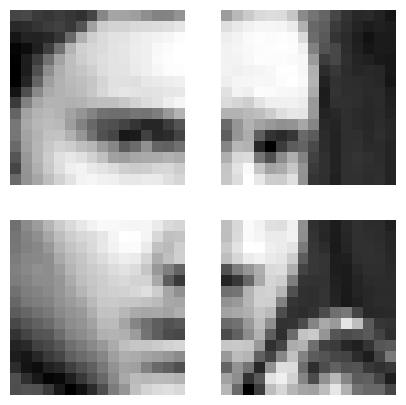

In [69]:
fer.imshow_patches(patches)

In [70]:
# actually we need to flatten all the patches individually .. and then make a single x out of it
class FerDataset(utils.data.Dataset):
    """
    Keep the validation
    and test set seperate for now.
    Dont plan to use early stopping.
    just to make sure we are not leaking into validation Dataset
    """

    def __init__(self,df,label = None, transformations = None):
        super().__init__()
        if label not in ("train", "test", "valid"):
            raise ValueError("Please give al label to this dataset class train , valid , test")

        # handy stuff that i often call
        self.label = label

        self.data = df[df.columns[:-1]] # the last column is just usage
        self.columns = self.data.columns
        self.shape = self.data.shape
        self.transforms = transformations

        if self.transforms is None:
            self.transforms = transforms.Compose([
                transforms.ToTensor(), # this actually makes the images [0,1] but we want to keep it in uint8 as we are going to pass it through an embedding layer
                transforms.Resize((32,32), antialias=True)]) # limit number of patches (4) calculation.. keep this a multiple of 16*16

    # mandatory method to calculate random indexes when you turn on shuffle in dataloader
    def __len__(self):
        return self.shape[0]


    def get_patches(self, arr):
        # expects a 32 , 32 image
        # and we return back (32/16) * (32/16) = 4 patches
        # remember first dimension is batch dimension
        # you cant use view to reshape here as the patches are not contiguous in memory
        # use reshape instead .. 
        tl = arr[:,:16, :16].reshape(-1, 16*16)
        tr = arr[:,:16,16:].reshape(-1, 16*16)
        bl = arr[:,16:,:16].reshape(-1, 16*16)
        br = arr[:,16:,16:].reshape(-1,16*16)
        return torch.cat([tl,tr,bl,br] , dim=1)


    def __getitem__(self, idx):
        # convert to string type

        self.data = self.data.astype({"emotion": int, "pixels": str})

        features = self.data.iloc[idx]['pixels']
        features = np.array(features.split(" "),dtype=np.uint8) # its a flatten of 48 * 48 * 1 image
        # image = features.view(48,48) -> numpy view is like astype with view not like torch.view
        image = features.reshape(48,48)
        if self.transforms:
            image = self.transforms(image)
        patches = self.get_patches(image)

        label = self.data.iloc[idx]['emotion']


        return patches, label # dont use capital Tensor it will convert it into float

   

In [71]:
fer = FerDataset(fer_train, "train")
patches,lab = fer[0]
# 16*16*4 = 1024
type(patches) , patches.shape , lab

(torch.Tensor, torch.Size([1, 1024]), 0)

In [72]:
train_data = FerDataset(fer_train,"train")
train_loader = utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

In [73]:
for data in train_loader:
    img, label = data
    print(img.shape, label.shape)
    break

torch.Size([32, 1, 1024]) torch.Size([32])


In [74]:
# check appendix for unit test of this class
class SingleHead(nn.Module):
    """
    Implements a single head of attention (unmasked)
    """

    def __init__(self,n_embed=32,head_size=8):
        super().__init__()
        # single head
        self.head_size = torch.tensor(head_size)
        self.n_embed = torch.tensor(n_embed)
        self.Q = nn.Parameter( torch.randn(self.n_embed,head_size) * (1/torch.tensor(2.82)))
        self.K = nn.Parameter( torch.randn(self.n_embed,head_size) * (1/torch.tensor(2.82)))
        self.V = nn.Parameter( torch.randn(self.n_embed,head_size) * (1/torch.tensor(2.82)))

    def forward(self,x):
        query = x @ self.Q
        key =   x @ self.K
        value=  x @ self.V
        
        # hand implementation
        # scale => sqrt head size
        scale = 1 / torch.sqrt(self.head_size)

        # we will not use any masking here as its an image
        # and no dropout consideration in this implementation
        comm = query @ key.transpose(-2,-1)
        comm = comm* scale
        soft_comm = torch.softmax(comm, dim=2)
        att = soft_comm @ value
        
        return att

In [75]:
class Multihead(nn.Module):
    def __init__(self,n_embed,n_heads):
        super().__init__()
        
        self.n_embed = n_embed
        self.n_heads = n_heads
        self.head_size = self.n_embed // self.n_heads
 
        self.multiheads = nn.ModuleList(
            [SingleHead(self.n_embed,self.head_size)
             for _ in range(self.n_heads)]
        )

    def forward(self,x):
        return torch.cat([head(x) for head in self.multiheads],dim=2)

In [76]:
# only multihead ->  skip connection -> layernorm
# Batch norm : couples examples in and normalizes it .. (also has a regularization effect) but we need to keep a running mean to track new mean and sigma
# layernorm : normalizes the features of each example (does not couple examples across the batch) more popular in transformers

class TranformerBlock(nn.Module):
    def __init__(self, n_embed,n_head):
        super().__init__()
        self.multi_head = Multihead(n_embed,n_head)
        # i am not going to implement my own layer norm it wont be efficient and will be janky at best
        self.norm = nn.LayerNorm(n_embed) # we want to normalize feeatures (each patch gets normalized)
    
    def forward(self,x):
        # pass through multihead
        attention = self.multi_head(x)
        # skip connection and non linarity
        attention = torch.relu( x + attention)
        # layer norm
        attention = self.norm(attention)
        return attention # B , n_patch , n_embed
        ...

In [77]:
# most of the comments are pasted verbatim from the paper
class SmallVIT(nn.Module):
    
    def __init__(self):
        super().__init__()
        # patches
        # embedding
        self.vocab_size = torch.tensor(256) # 0 to 255 pixels
        # each patch will only get one n_embed representation
        self.n_embed = 32 # we will project each patch 16*16 to a 32 dimensional representation
        # so the lookup table would be of the shape
        # unlike in nlp where we embed token to a vector like below we would project matrix of patch size to a vector
        # self.C = nn.Embedding(self.vocab_size, self.n_embed)
        
        self.C = nn.Parameter(torch.randn(self.vocab_size, self.n_embed) * 1/torch.sqrt(self.vocab_size) )
        
        # positional embedding
        # the paper says Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings 
        self.pe = nn.Parameter(torch.randn(1,4,self.n_embed)) # each pach and representation should get positional embedding
        
        # we use the standard approach of adding an extra learnable “classification token” to the sequence
        self.classification_token = nn.Parameter(torch.randn(1, 1, self.n_embed))
        # we will keep the step above optional .. i dont understand why we should use it yet.
        
        # transformer block
        self.n_heads = 4 # we will use 4 heads for now
        self.transformer_block = TranformerBlock(self.n_embed,self.n_heads)
        
        # MLP Head for final logit calculation
        # n_patch * n_embed -> fer["emotion"].nuinque() : 7
        self.mlp_head = nn.Parameter(torch.randn(4*32, 7) * torch.sqrt(torch.tensor(4*32)))
        
        
        
        
        ...
       
    def forward(self,X):
        batch_size = X.shape[0]
        patches = X.view(-1,4,256) # B , p_num , 16*16
        # B , p_num , 256 @ 256 , 32
        emb = patches @ self.C # B , p_num , n_embed
        emb = emb + self.pe # kind of acts like a bias towards each patches.
        
        # 2 transformers
        tf = self.transformer_block(emb)
        tf = self.transformer_block(tf)
        
        # flatten it : across patches
        tf = tf.view(batch_size,-1)
        
        # logits
        logits = tf @ self.mlp_head
        
        
        

        # broadcasting steps in the above command
        # B,p_n , p*p , n_embed
        #1,4,32


        return logits

        
        
        
        
        

In [78]:
vit = SmallVIT()
x_ex, y_ex = train_data[0]
with torch.no_grad() :
    o = vit(x_ex)
    print(o, o.shape)

tensor([[ 118.2324,   11.9539,  -52.9618,    8.2771,   67.1156,  -16.5102,
         -133.9027]]) torch.Size([1, 7])


In [79]:
optimizer = torch.optim.AdamW(vit.parameters(),lr=1e-3)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [80]:
track_loss = list()

In [93]:
from tqdm import tqdm
for epoch in range(10):
    # running on cpu so just 1 epoch
    for batch_idx, (Xb, yb) in tqdm( enumerate(train_loader)):

        # forward pass
        logits = vit(Xb)

        # loss
        loss = nn.functional.cross_entropy(logits,yb)

        # flush the gradients 
        optimizer.zero_grad(set_to_none=True)

        # backprop
        loss.backward()

        # learning step
        optimizer.step()

        # for plotting
        track_loss.append(loss.item())



898it [00:39, 22.75it/s]
898it [00:39, 22.96it/s]
898it [00:39, 22.72it/s]
898it [00:39, 22.83it/s]
898it [00:39, 22.59it/s]
898it [00:39, 22.73it/s]
898it [00:39, 22.67it/s]
898it [00:39, 22.71it/s]
898it [00:39, 22.59it/s]
898it [00:39, 22.59it/s]


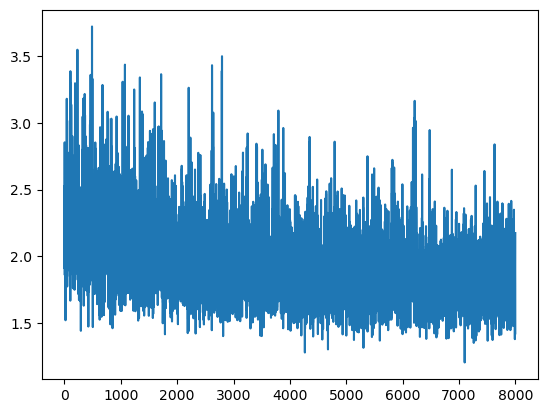

In [101]:
plt.plot(track_loss[-8000:])

In [95]:
np.median(
    track_loss[:-10]
)

1.9874691367149353

(array([ 1.,  3.,  3., 10.,  5.,  4.,  3.,  3.,  1.,  2.]),
 array([43.80527496, 44.75465012, 45.70402527, 46.65339661, 47.60277176,
        48.55214691, 49.50152206, 50.45089722, 51.40026855, 52.34964371,
        53.29901886]),
 <BarContainer object of 10 artists>)

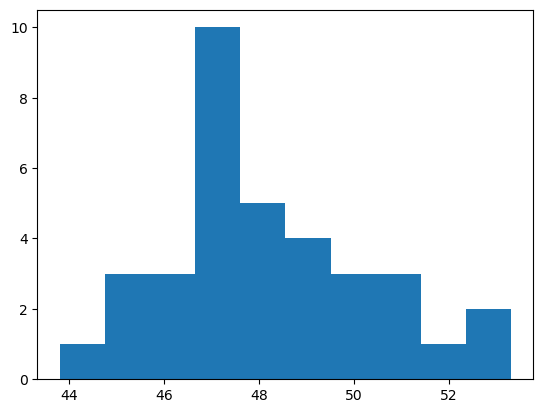

In [108]:
import einops # the logits have tended to give roughly uniform dist . now 
# almost equalling the expected loss
logits = einops.asnumpy(logits)
plt.hist(einops.rearrange(logits,"r c -> (r c)"))

In [96]:
# the expected loss
# if we get equal values in the logits
-1 * np.log(1/7)

1.9459101490553135

In [97]:
# we will try to improve on this in vit_pretrained notebook

# Appendix

In [98]:
# unit teset

# single head unit test

In [85]:
g=torch.Generator().manual_seed(123)
query, key, value = torch.randn(2, 3, 8 , generator = g), torch.randn(2, 3, 8, generator = g), torch.randn(2, 3, 8 , generator = g)

In [86]:
# pytorch implementation
py_sa = nn.functional.scaled_dot_product_attention(query, key, value)
py_sa.shape

torch.Size([2, 3, 8])

In [87]:
def single_head(query, key,value):
    head_size = torch.tensor(query.shape[-1])
    # hand implementation
    # scale => sqrt head size
    scale = 1 / torch.sqrt(head_size)

    # we will not use any masking here as its an image
    # and no dropout consideration in this implementation
    comm = query @ key.transpose(-2,-1)
    comm = comm* scale
    soft_comm = torch.softmax(comm, dim=2)
    att = soft_comm @ value
    print(att.shape)
    return att
sh  = single_head(query,key,value)

torch.Size([2, 3, 8])


In [88]:
torch.allclose(py_sa , sh)

True

In [89]:
fer_train["emotion"].nunique()

7